<a href="https://colab.research.google.com/github/kudanzakalabo/seminar/blob/main/Pytorch_LSTM_%E6%BC%94%E7%BF%92_%E3%83%AC%E3%83%B3%E3%82%BF%E3%83%AB%E8%87%AA%E8%BB%A2%E8%BB%8A_AblationWeather%E5%A4%89%E6%95%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#レンタル自転車の利用者数予測問題

https://signate.jp/competitions/114

#ライブラリ

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [67]:
from time import time
from datetime import timedelta

# Pytorch ライブラリ

In [68]:
from torch import nn
from torch.nn import LSTM, Embedding, Linear
from torch.nn.functional import one_hot
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

#データ

In [69]:
#df_rent_train = pd.read_table("rent_train.tsv")
df_rent_train = pd.read_table('https://tus.box.com/shared/static/bnc2uu2auq466c6zcc31xawmaezdgcmo.tsv')
df_rent_train

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,8641,2011-12-31,1,0,12,19,0,6,0,1,0.42,0.4242,0.54,0.2239,92
8641,8642,2011-12-31,1,0,12,20,0,6,0,1,0.42,0.4242,0.54,0.2239,71
8642,8643,2011-12-31,1,0,12,21,0,6,0,1,0.40,0.4091,0.58,0.1940,52
8643,8644,2011-12-31,1,0,12,22,0,6,0,1,0.38,0.3939,0.62,0.1343,38


In [70]:
#データ型確認
df_rent_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8645 entries, 0 to 8644
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8645 non-null   int64  
 1   dteday      8645 non-null   object 
 2   season      8645 non-null   int64  
 3   yr          8645 non-null   int64  
 4   mnth        8645 non-null   int64  
 5   hr          8645 non-null   int64  
 6   holiday     8645 non-null   int64  
 7   weekday     8645 non-null   int64  
 8   workingday  8645 non-null   int64  
 9   weathersit  8645 non-null   int64  
 10  temp        8645 non-null   float64
 11  atemp       8645 non-null   float64
 12  hum         8645 non-null   float64
 13  windspeed   8645 non-null   float64
 14  cnt         8645 non-null   int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 1013.2+ KB


In [71]:
#テストコード - 日付フォーマット
df_rent_train[['dteday','hr']].apply(lambda x: x['dteday'] + ' ' + str(x['hr'])+':00', axis=1)

0        2011-01-01 0:00
1        2011-01-01 1:00
2        2011-01-01 2:00
3        2011-01-01 3:00
4        2011-01-01 4:00
              ...       
8640    2011-12-31 19:00
8641    2011-12-31 20:00
8642    2011-12-31 21:00
8643    2011-12-31 22:00
8644    2011-12-31 23:00
Length: 8645, dtype: object

In [72]:
#テストコード - 日付フォーマット
pd.to_datetime(df_rent_train[['dteday','hr']].apply(lambda x: x['dteday'] + ' ' + str(x['hr'])+':00', axis=1))

0      2011-01-01 00:00:00
1      2011-01-01 01:00:00
2      2011-01-01 02:00:00
3      2011-01-01 03:00:00
4      2011-01-01 04:00:00
               ...        
8640   2011-12-31 19:00:00
8641   2011-12-31 20:00:00
8642   2011-12-31 21:00:00
8643   2011-12-31 22:00:00
8644   2011-12-31 23:00:00
Length: 8645, dtype: datetime64[ns]

In [73]:
df_dateindex = df_rent_train.set_index(pd.to_datetime(df_rent_train[['dteday','hr']].apply(lambda x: x['dteday'] + ' ' + str(x['hr'])+':00', axis=1)))
df_dateindex

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31 19:00:00,8641,2011-12-31,1,0,12,19,0,6,0,1,0.42,0.4242,0.54,0.2239,92
2011-12-31 20:00:00,8642,2011-12-31,1,0,12,20,0,6,0,1,0.42,0.4242,0.54,0.2239,71
2011-12-31 21:00:00,8643,2011-12-31,1,0,12,21,0,6,0,1,0.40,0.4091,0.58,0.1940,52
2011-12-31 22:00:00,8644,2011-12-31,1,0,12,22,0,6,0,1,0.38,0.3939,0.62,0.1343,38


In [74]:
df_dateindex.describe()

,id,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,8645.000000,8645.000000,8645.0,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.00000,8645.000000,8645.000000,8645.000000
mean,4323.000000,2.513592,0.0,6.573973,11.573626,0.027646,3.012724,0.683748,1.437594,0.489069,0.46900,0.643430,0.191172,143.794448
std,2495.740872,1.105477,0.0,3.428147,6.907822,0.163966,2.006370,0.465040,0.653859,0.197943,0.17676,0.196293,0.123191,133.797854
min,1.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.00000,0.000000,0.000000,1.000000
25%,2162.000000,2.000000,0.0,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.320000,0.31820,0.490000,0.104500,31.000000
50%,4323.000000,3.000000,0.0,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.48480,0.650000,0.194000,109.000000
75%,6484.000000,3.000000,0.0,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.62120,0.810000,0.283600,211.000000
max,8645.000000,4.000000,0.0,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.960000,1.00000,1.000000,0.850700,651.000000


#基礎分析

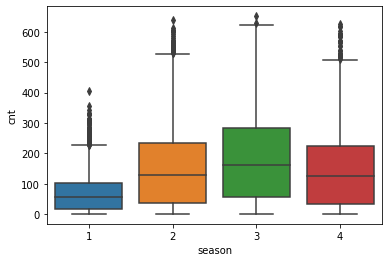

In [75]:
sns.boxplot(data=df_dateindex, x='season',y='cnt')

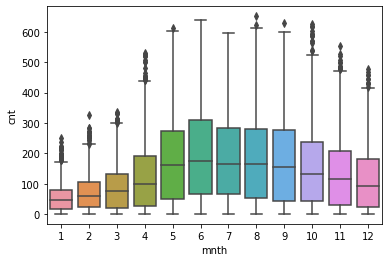

In [76]:
sns.boxplot(data=df_dateindex, x='mnth',y='cnt')

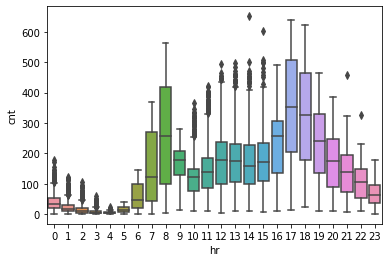

In [77]:
sns.boxplot(data=df_dateindex,x='hr',y='cnt')

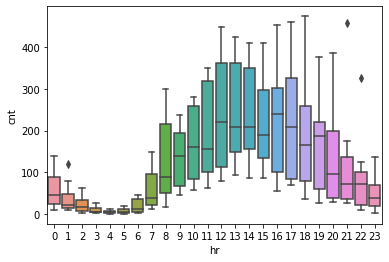

In [78]:
sns.boxplot(data=df_dateindex[df_dateindex['holiday']==1],x='hr',y='cnt')

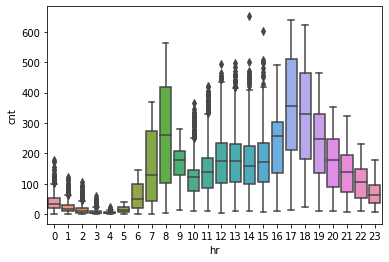

In [79]:
sns.boxplot(data=df_dateindex[df_dateindex['holiday']==0],x='hr',y='cnt')

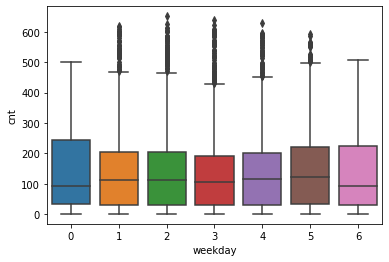

In [80]:
sns.boxplot(data=df_dateindex,x='weekday',y='cnt')

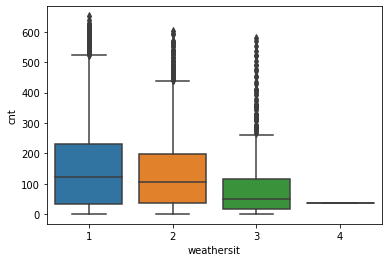

In [81]:
sns.boxplot(data=df_dateindex,x='weathersit',y='cnt')

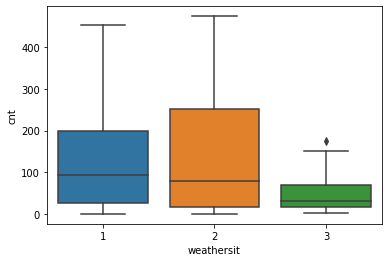

In [82]:
sns.boxplot(data=df_dateindex[df_dateindex['holiday']==1],x='weathersit',y='cnt')

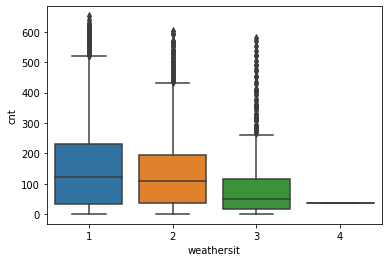

In [83]:
sns.boxplot(data=df_dateindex[df_dateindex['holiday']==0],x='weathersit',y='cnt')

In [84]:
import numpy as np

In [85]:
df_dateindex.assign(temp=df_dateindex.temp.apply(lambda x: np.round(10*x)))

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,2.0,0.2879,0.81,0.0000,16
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,2.0,0.2727,0.80,0.0000,40
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,2.0,0.2727,0.80,0.0000,32
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,2.0,0.2879,0.75,0.0000,13
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,2.0,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31 19:00:00,8641,2011-12-31,1,0,12,19,0,6,0,1,4.0,0.4242,0.54,0.2239,92
2011-12-31 20:00:00,8642,2011-12-31,1,0,12,20,0,6,0,1,4.0,0.4242,0.54,0.2239,71
2011-12-31 21:00:00,8643,2011-12-31,1,0,12,21,0,6,0,1,4.0,0.4091,0.58,0.1940,52
2011-12-31 22:00:00,8644,2011-12-31,1,0,12,22,0,6,0,1,4.0,0.3939,0.62,0.1343,38


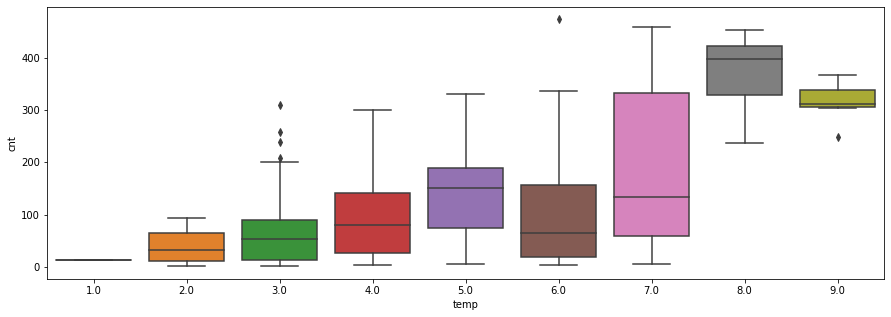

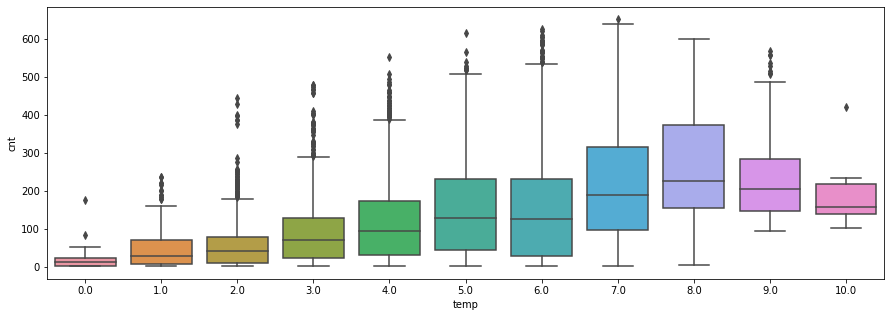

In [86]:
plt.figure(figsize=(15,5))
sns.boxplot(data=_[df_dateindex['holiday']==1],x='temp',y='cnt')
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data=_[df_dateindex['holiday']==0],x='temp',y='cnt')
plt.show()

In [87]:
df_dateindex.assign(atemp=df_dateindex.atemp.apply(lambda x: np.round(10*x)))

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,3.0,0.81,0.0000,16
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,3.0,0.80,0.0000,40
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,3.0,0.80,0.0000,32
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,3.0,0.75,0.0000,13
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,3.0,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31 19:00:00,8641,2011-12-31,1,0,12,19,0,6,0,1,0.42,4.0,0.54,0.2239,92
2011-12-31 20:00:00,8642,2011-12-31,1,0,12,20,0,6,0,1,0.42,4.0,0.54,0.2239,71
2011-12-31 21:00:00,8643,2011-12-31,1,0,12,21,0,6,0,1,0.40,4.0,0.58,0.1940,52
2011-12-31 22:00:00,8644,2011-12-31,1,0,12,22,0,6,0,1,0.38,4.0,0.62,0.1343,38


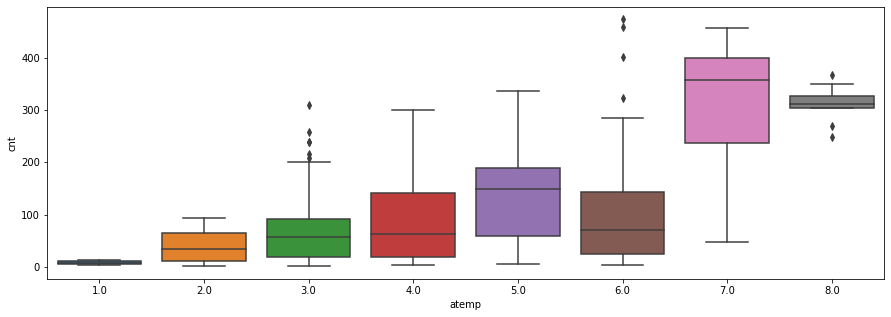

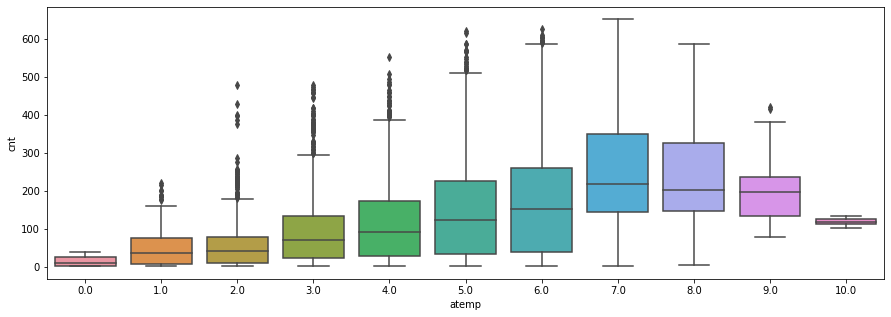

In [88]:
plt.figure(figsize=(15,5))
sns.boxplot(data=_[df_dateindex['holiday']==1],x='atemp',y='cnt')
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data=_[df_dateindex['holiday']==0],x='atemp',y='cnt')
plt.show()

In [89]:
df_dateindex.assign(hum=df_dateindex.hum.apply(lambda x: np.round(10*x)))

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,8.0,0.0000,16
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,8.0,0.0000,40
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,8.0,0.0000,32
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,8.0,0.0000,13
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,8.0,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31 19:00:00,8641,2011-12-31,1,0,12,19,0,6,0,1,0.42,0.4242,5.0,0.2239,92
2011-12-31 20:00:00,8642,2011-12-31,1,0,12,20,0,6,0,1,0.42,0.4242,5.0,0.2239,71
2011-12-31 21:00:00,8643,2011-12-31,1,0,12,21,0,6,0,1,0.40,0.4091,6.0,0.1940,52
2011-12-31 22:00:00,8644,2011-12-31,1,0,12,22,0,6,0,1,0.38,0.3939,6.0,0.1343,38


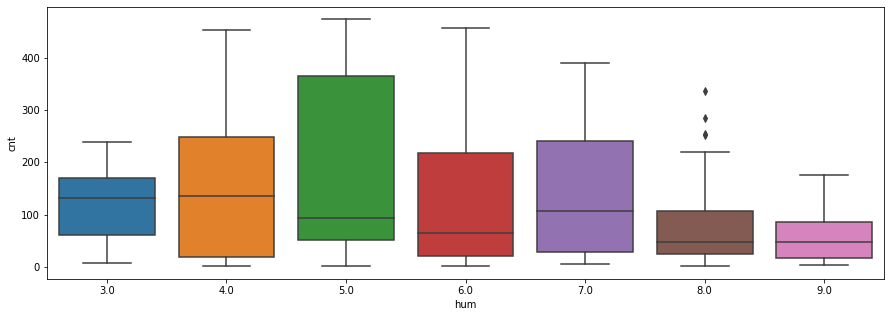

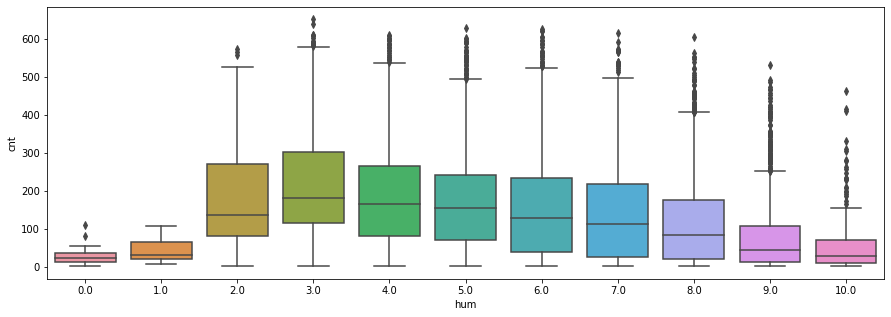

In [90]:
plt.figure(figsize=(15,5))
sns.boxplot(data=_[df_dateindex['holiday']==1],x='hum',y='cnt')
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data=_[df_dateindex['holiday']==0],x='hum',y='cnt')
plt.show()

In [91]:
df_dateindex.assign(windspeed=df_dateindex.windspeed.apply(lambda x: np.round(10*x)))

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31 19:00:00,8641,2011-12-31,1,0,12,19,0,6,0,1,0.42,0.4242,0.54,2.0,92
2011-12-31 20:00:00,8642,2011-12-31,1,0,12,20,0,6,0,1,0.42,0.4242,0.54,2.0,71
2011-12-31 21:00:00,8643,2011-12-31,1,0,12,21,0,6,0,1,0.40,0.4091,0.58,2.0,52
2011-12-31 22:00:00,8644,2011-12-31,1,0,12,22,0,6,0,1,0.38,0.3939,0.62,1.0,38


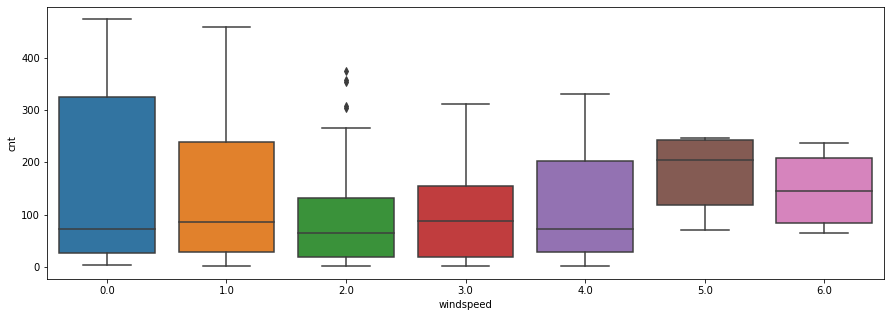

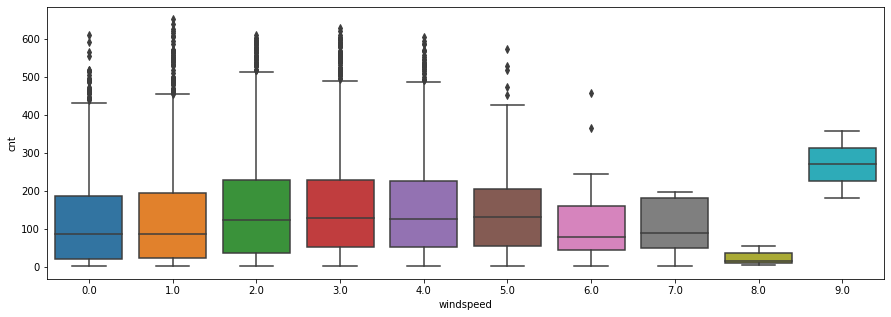

In [92]:
plt.figure(figsize=(15,5))
sns.boxplot(data=_[df_dateindex['holiday']==1],x='windspeed',y='cnt')
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data=_[df_dateindex['holiday']==0],x='windspeed',y='cnt')
plt.show()

#時系列可視化

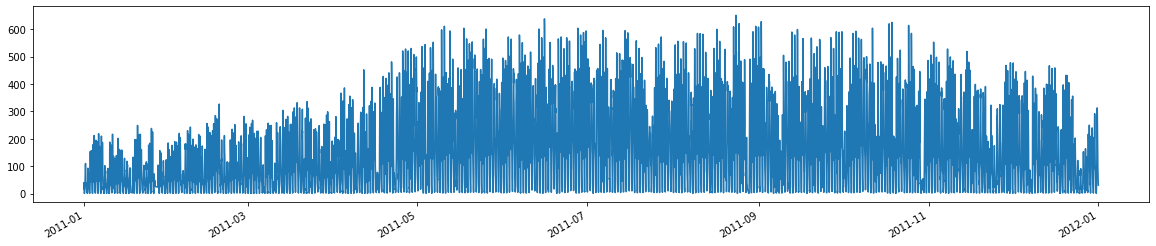

In [93]:
df_dateindex.cnt.plot(figsize=(20,4))

In [94]:
日毎合計 = df_dateindex.groupby('dteday').sum()

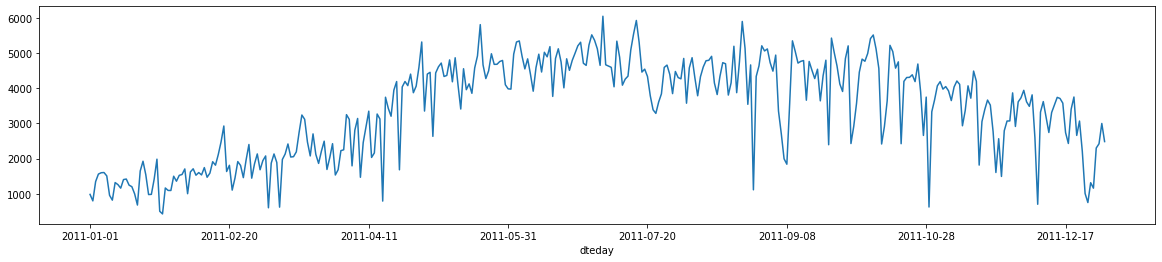

In [95]:
日毎合計.cnt.plot(figsize=(20,4))

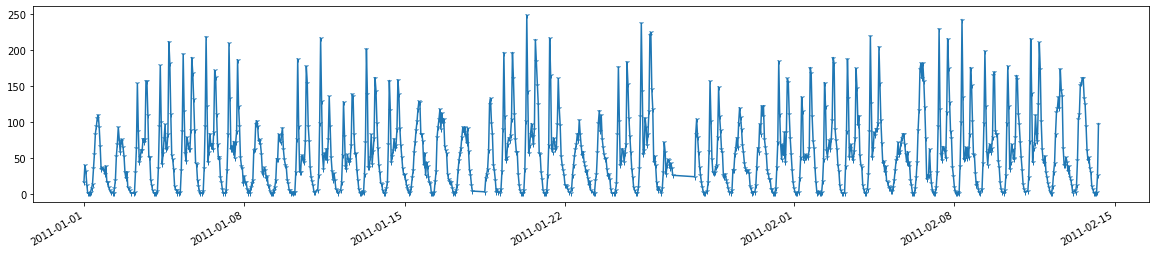

In [96]:
df_dateindex['cnt'][:1000].plot(figsize=(20,4), marker='1')

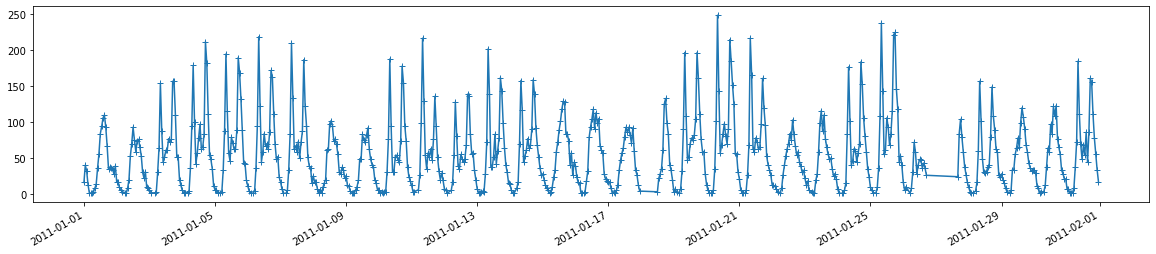

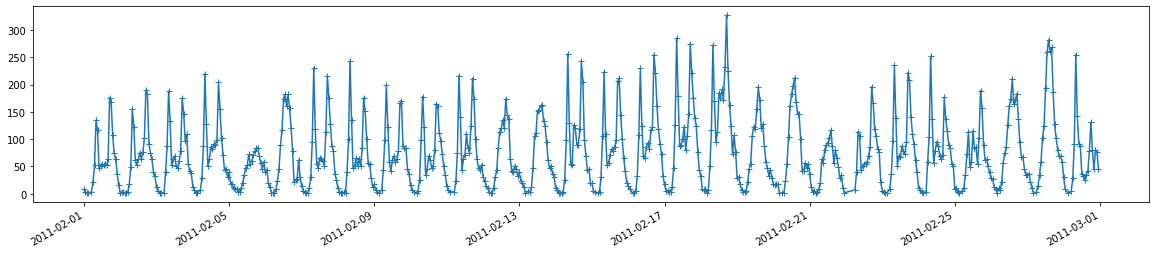

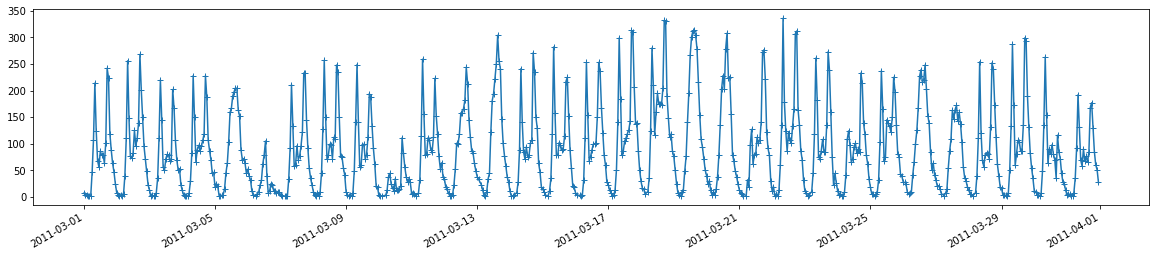

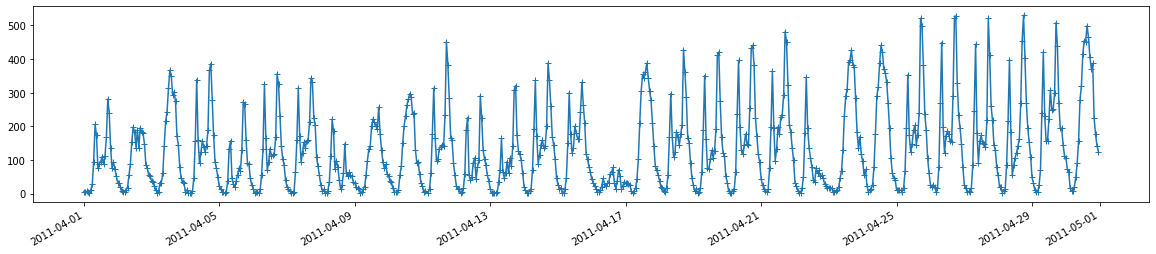

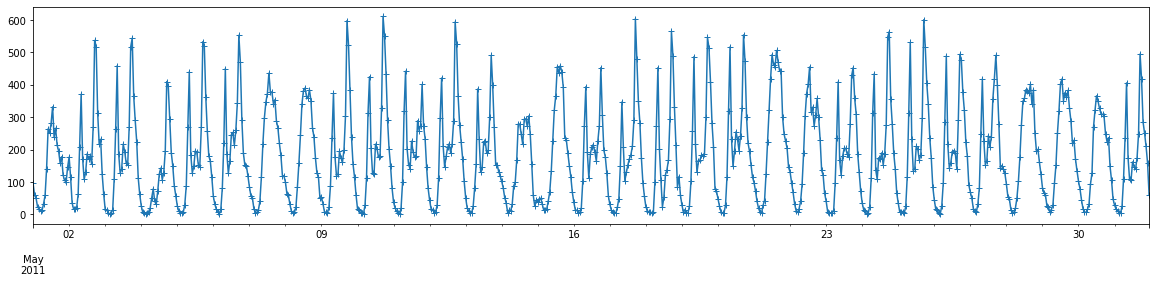

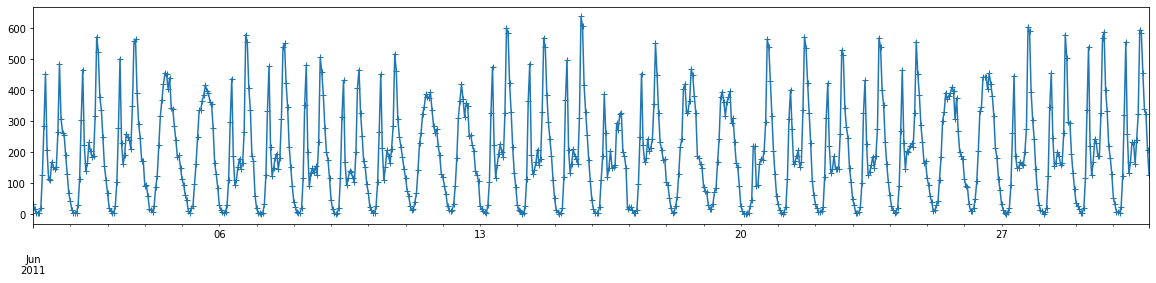

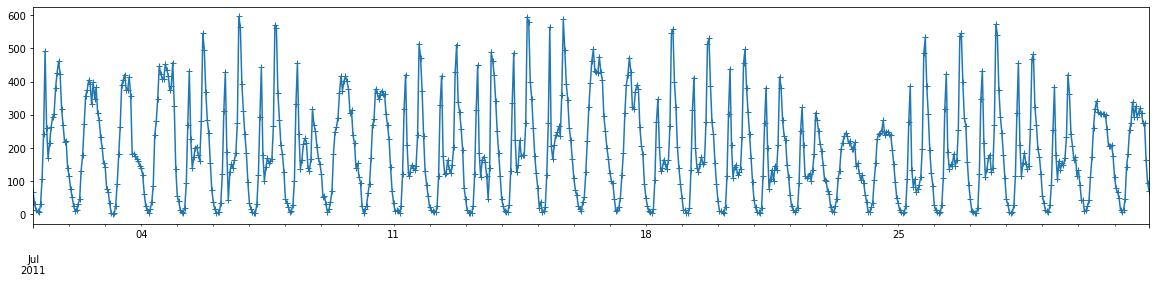

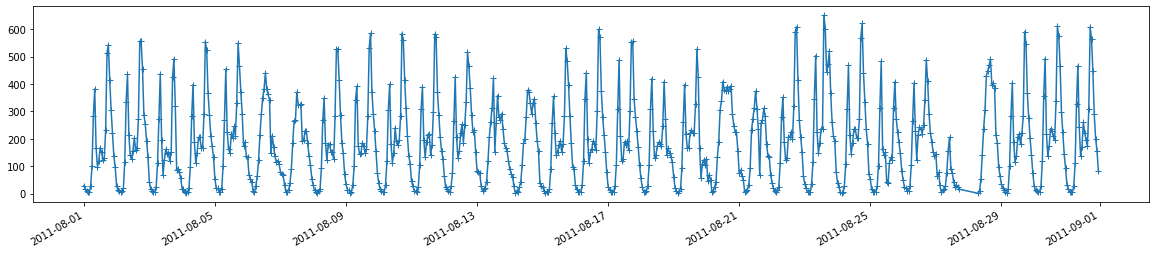

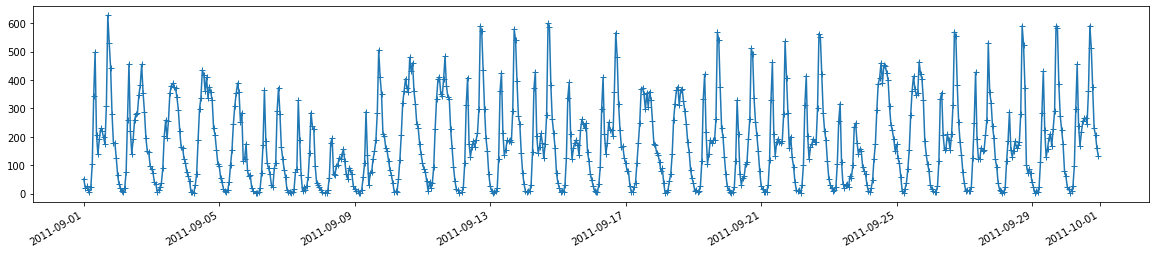

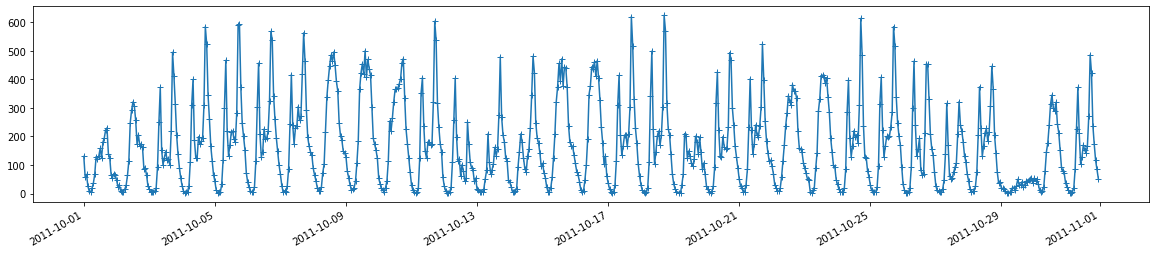

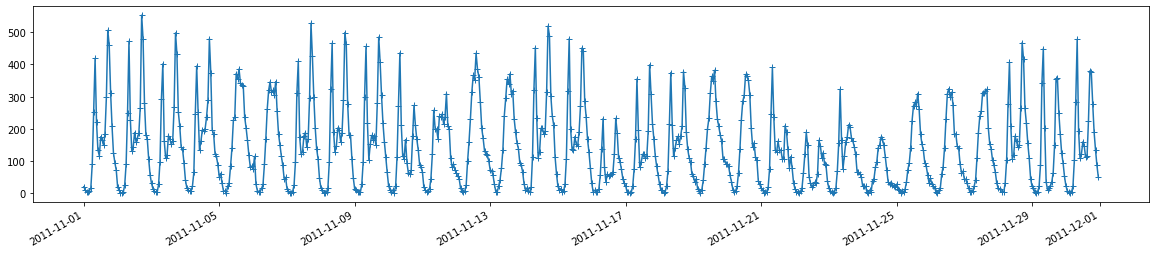

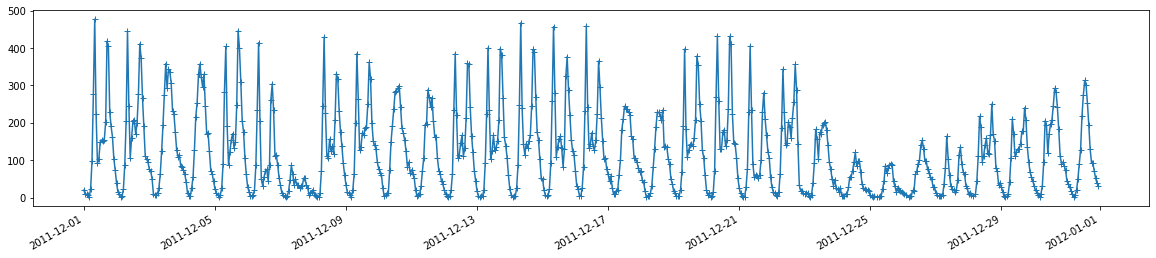

In [97]:
for i,j in df_dateindex.groupby('mnth'):
  j.cnt.plot(figsize=(20,4), marker='+')
  plt.show()

#部分系列データの整形

##スケーリング・正規化

In [98]:
for i in ['season','mnth','weekday','workingday','weathersit','hr']:
  print(i, df_dateindex[i].value_counts().sort_index().index)

season Int64Index([1, 2, 3, 4], dtype='int64')
mnth Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')
weekday Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
workingday Int64Index([0, 1], dtype='int64')
weathersit Int64Index([1, 2, 3, 4], dtype='int64')
hr Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64')


In [99]:
df_scaled = df_dateindex.assign(cnt = df_dateindex.cnt / df_dateindex.cnt.median()).assign(weathersit = df_dateindex.weathersit -1).assign(season = df_dateindex.season -1).assign(mnth = df_dateindex.mnth -1)

##欠損の補完

In [100]:
daterange = pd.date_range(start=df_dateindex.index[0], end=df_dateindex.index[-1], freq='H')
daterange

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2011-12-31 14:00:00', '2011-12-31 15:00:00',
               '2011-12-31 16:00:00', '2011-12-31 17:00:00',
               '2011-12-31 18:00:00', '2011-12-31 19:00:00',
               '2011-12-31 20:00:00', '2011-12-31 21:00:00',
               '2011-12-31 22:00:00', '2011-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq='H')

In [101]:
df_daterange=pd.Series(range(len(daterange)),index=daterange,name='date_id')

In [102]:
df_nan = pd.merge(df_scaled, df_daterange, left_index=True, right_index=True, how='outer')
df_nan.isna().sum()

id            115
dteday        115
season        115
yr            115
mnth          115
hr            115
holiday       115
weekday       115
workingday    115
weathersit    115
temp          115
atemp         115
hum           115
windspeed     115
cnt           115
date_id         0
dtype: int64

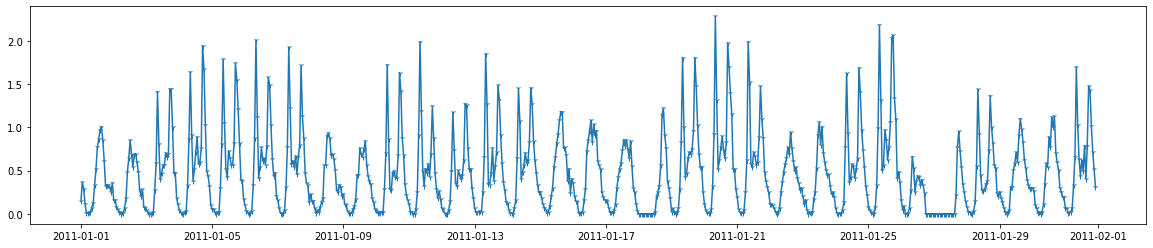

In [103]:
plt.figure(figsize=(20,4))
plt.plot(df_nan.iloc[:743].cnt.fillna(0),marker='1')
plt.show()

##部分系列の分割

In [136]:
df_nan.cnt = df_nan.cnt.fillna(0)
df_nan = df_nan.ffill()

In [178]:
#@title 系列長パラメタ
length_pred = 24 #@param
#ターゲット期間
length_target = 2 #@param
#部分系列長=予測変数長+ターゲット期間
length_ss = length_pred + length_target

In [179]:
#groupby <-> resample (時間インデックスで使用可能)
[j for i,j in df_nan.resample('24h')][0]

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,date_id
2011-01-01 00:00:00,1.0,2011-01-01,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.24,0.2879,0.81,0.0000,0.146789,0
2011-01-01 01:00:00,2.0,2011-01-01,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.22,0.2727,0.80,0.0000,0.366972,1
2011-01-01 02:00:00,3.0,2011-01-01,0.0,0.0,0.0,2.0,0.0,6.0,0.0,0.0,0.22,0.2727,0.80,0.0000,0.293578,2
2011-01-01 03:00:00,4.0,2011-01-01,0.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.24,0.2879,0.75,0.0000,0.119266,3
2011-01-01 04:00:00,5.0,2011-01-01,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.24,0.2879,0.75,0.0000,0.009174,4
2011-01-01 05:00:00,6.0,2011-01-01,0.0,0.0,0.0,5.0,0.0,6.0,0.0,1.0,0.24,0.2576,0.75,0.0896,0.009174,5
2011-01-01 06:00:00,7.0,2011-01-01,0.0,0.0,0.0,6.0,0.0,6.0,0.0,0.0,0.22,0.2727,0.80,0.0000,0.018349,6
2011-01-01 07:00:00,8.0,2011-01-01,0.0,0.0,0.0,7.0,0.0,6.0,0.0,0.0,0.20,0.2576,0.86,0.0000,0.027523,7
2011-01-01 08:00:00,9.0,2011-01-01,0.0,0.0,0.0,8.0,0.0,6.0,0.0,0.0,0.24,0.2879,0.75,0.0000,0.073394,8
2011-01-01 09:00:00,10.0,2011-01-01,0.0,0.0,0.0,9.0,0.0,6.0,0.0,0.0,0.32,0.3485,0.76,0.0000,0.128440,9


In [180]:
#データフレームの各行をリストでまとめる
df_nan.resample('24h').aggregate(list).head(2)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,date_id
2011-01-01,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[2011-01-01, 2011-01-01, 2011-01-01, 2011-01-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.24, 0.22, 0.22, 0.24, 0.24, 0.24, 0.22, 0.2...","[0.2879, 0.2727, 0.2727, 0.2879, 0.2879, 0.257...","[0.81, 0.8, 0.8, 0.75, 0.75, 0.75, 0.8, 0.86, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0896, 0.0, 0.0, 0....","[0.14678899082568808, 0.3669724770642202, 0.29...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2011-01-02,"[25.0, 26.0, 27.0, 28.0, 29.0, 29.0, 30.0, 31....","[2011-01-02, 2011-01-02, 2011-01-02, 2011-01-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 4.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, ...","[0.46, 0.44, 0.42, 0.46, 0.46, 0.46, 0.42, 0.4...","[0.4545, 0.4394, 0.4242, 0.4545, 0.4545, 0.454...","[0.88, 0.94, 1.0, 0.94, 0.94, 0.94, 0.77, 0.76...","[0.2985, 0.2537, 0.2836, 0.1939999999999999, 0...","[0.1559633027522936, 0.1559633027522936, 0.082...","[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3..."


In [181]:
df_nan.resample('24h',offset='23h').aggregate(list).head(2)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,date_id
2010-12-31 23:00:00,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[2011-01-01, 2011-01-01, 2011-01-01, 2011-01-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.24, 0.22, 0.22, 0.24, 0.24, 0.24, 0.22, 0.2...","[0.2879, 0.2727, 0.2727, 0.2879, 0.2879, 0.257...","[0.81, 0.8, 0.8, 0.75, 0.75, 0.75, 0.8, 0.86, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0896, 0.0, 0.0, 0....","[0.14678899082568808, 0.3669724770642202, 0.29...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2011-01-01 23:00:00,"[24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 29.0, 30....","[2011-01-01, 2011-01-02, 2011-01-02, 2011-01-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[23.0, 0.0, 1.0, 2.0, 3.0, 4.0, 4.0, 6.0, 7.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[0.46, 0.46, 0.44, 0.42, 0.46, 0.46, 0.46, 0.4...","[0.4545, 0.4545, 0.4394, 0.4242, 0.4545, 0.454...","[0.88, 0.88, 0.94, 1.0, 0.94, 0.94, 0.94, 0.77...","[0.2985, 0.2985, 0.2537, 0.2836, 0.19399999999...","[0.3577981651376147, 0.1559633027522936, 0.155...","[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3..."


In [182]:
pd.concat([df_nan.resample('4h',offset=str(i)+'h').aggregate(list) for i in range(4)]).sort_index()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,date_id
2010-12-31 21:00:00,[1.0],[2011-01-01],[0.0],[0.0],[0.0],[0.0],[0.0],[6.0],[0.0],[0.0],[0.24],[0.2879],[0.81],[0.0],[0.14678899082568808],[0]
2010-12-31 22:00:00,"[1.0, 2.0]","[2011-01-01, 2011-01-01]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 1.0]","[0.0, 0.0]","[6.0, 6.0]","[0.0, 0.0]","[0.0, 0.0]","[0.24, 0.22]","[0.2879, 0.2727]","[0.81, 0.8]","[0.0, 0.0]","[0.14678899082568808, 0.3669724770642202]","[0, 1]"
2010-12-31 23:00:00,"[1.0, 2.0, 3.0]","[2011-01-01, 2011-01-01, 2011-01-01]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 2.0]","[0.0, 0.0, 0.0]","[6.0, 6.0, 6.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.24, 0.22, 0.22]","[0.2879, 0.2727, 0.2727]","[0.81, 0.8, 0.8]","[0.0, 0.0, 0.0]","[0.14678899082568808, 0.3669724770642202, 0.29...","[0, 1, 2]"
2011-01-01 00:00:00,"[1.0, 2.0, 3.0, 4.0]","[2011-01-01, 2011-01-01, 2011-01-01, 2011-01-01]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 2.0, 3.0]","[0.0, 0.0, 0.0, 0.0]","[6.0, 6.0, 6.0, 6.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.24, 0.22, 0.22, 0.24]","[0.2879, 0.2727, 0.2727, 0.2879]","[0.81, 0.8, 0.8, 0.75]","[0.0, 0.0, 0.0, 0.0]","[0.14678899082568808, 0.3669724770642202, 0.29...","[0, 1, 2, 3]"
2011-01-01 01:00:00,"[2.0, 3.0, 4.0, 5.0]","[2011-01-01, 2011-01-01, 2011-01-01, 2011-01-01]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[1.0, 2.0, 3.0, 4.0]","[0.0, 0.0, 0.0, 0.0]","[6.0, 6.0, 6.0, 6.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.22, 0.22, 0.24, 0.24]","[0.2727, 0.2727, 0.2879, 0.2879]","[0.8, 0.8, 0.75, 0.75]","[0.0, 0.0, 0.0, 0.0]","[0.3669724770642202, 0.29357798165137616, 0.11...","[1, 2, 3, 4]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31 19:00:00,"[8641.0, 8642.0, 8643.0, 8644.0]","[2011-12-31, 2011-12-31, 2011-12-31, 2011-12-31]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[11.0, 11.0, 11.0, 11.0]","[19.0, 20.0, 21.0, 22.0]","[0.0, 0.0, 0.0, 0.0]","[6.0, 6.0, 6.0, 6.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.42, 0.42, 0.4, 0.38]","[0.4242, 0.4242, 0.4091, 0.3939]","[0.54, 0.54, 0.58, 0.62]","[0.2239, 0.2239, 0.1939999999999999, 0.1343]","[0.8440366972477065, 0.6513761467889908, 0.477...","[8755, 8756, 8757, 8758]"
2011-12-31 20:00:00,"[8642.0, 8643.0, 8644.0, 8645.0]","[2011-12-31, 2011-12-31, 2011-12-31, 2011-12-31]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[11.0, 11.0, 11.0, 11.0]","[20.0, 21.0, 22.0, 23.0]","[0.0, 0.0, 0.0, 0.0]","[6.0, 6.0, 6.0, 6.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.42, 0.4, 0.38, 0.36]","[0.4242, 0.4091, 0.3939, 0.3788]","[0.54, 0.58, 0.62, 0.66]","[0.2239, 0.1939999999999999, 0.1343, 0.0]","[0.6513761467889908, 0.47706422018348627, 0.34...","[8756, 8757, 8758, 8759]"
2011-12-31 21:00:00,"[8643.0, 8644.0, 8645.0]","[2011-12-31, 2011-12-31, 2011-12-31]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[11.0, 11.0, 11.0]","[21.0, 22.0, 23.0]","[0.0, 0.0, 0.0]","[6.0, 6.0, 6.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.4, 0.38, 0.36]","[0.4091, 0.3939, 0.3788]","[0.58, 0.62, 0.66]","[0.1939999999999999, 0.1343, 0.0]","[0.47706422018348627, 0.3486238532110092, 0.28...","[8757, 8758, 8759]"
2011-12-31 22:00:00,"[8644.0, 8645.0]","[2011-12-31, 2011-12-31]","[0.0, 0.0]","[0.0, 0.0]","[11.0, 11.0]","[22.0, 23.0]","[0.0, 0.0]","[6.0, 6.0]","[0.0, 0.0]","[0.0, 0.0]","[0.38, 0.36]","[0.3939, 0.3788]","[0.62, 0.66]","[0.1343, 0.0]","[0.3486238532110092, 0.28440366972477066]","[8758, 8759]"


In [183]:
df_resample = pd.concat([df_nan.resample(str(length_ss)+'h',offset=str(i)+'h').aggregate(list) 
for i in range(length_ss)]).sort_index()
df_resample.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,date_id
2010-12-30 23:00:00,[1.0],[2011-01-01],[0.0],[0.0],[0.0],[0.0],[0.0],[6.0],[0.0],[0.0],[0.24],[0.2879],[0.81],[0.0],[0.14678899082568808],[0]
2010-12-31 00:00:00,"[1.0, 2.0]","[2011-01-01, 2011-01-01]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 1.0]","[0.0, 0.0]","[6.0, 6.0]","[0.0, 0.0]","[0.0, 0.0]","[0.24, 0.22]","[0.2879, 0.2727]","[0.81, 0.8]","[0.0, 0.0]","[0.14678899082568808, 0.3669724770642202]","[0, 1]"
2010-12-31 01:00:00,"[1.0, 2.0, 3.0]","[2011-01-01, 2011-01-01, 2011-01-01]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 2.0]","[0.0, 0.0, 0.0]","[6.0, 6.0, 6.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.24, 0.22, 0.22]","[0.2879, 0.2727, 0.2727]","[0.81, 0.8, 0.8]","[0.0, 0.0, 0.0]","[0.14678899082568808, 0.3669724770642202, 0.29...","[0, 1, 2]"
2010-12-31 02:00:00,"[1.0, 2.0, 3.0, 4.0]","[2011-01-01, 2011-01-01, 2011-01-01, 2011-01-01]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 2.0, 3.0]","[0.0, 0.0, 0.0, 0.0]","[6.0, 6.0, 6.0, 6.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.24, 0.22, 0.22, 0.24]","[0.2879, 0.2727, 0.2727, 0.2879]","[0.81, 0.8, 0.8, 0.75]","[0.0, 0.0, 0.0, 0.0]","[0.14678899082568808, 0.3669724770642202, 0.29...","[0, 1, 2, 3]"
2010-12-31 03:00:00,"[1.0, 2.0, 3.0, 4.0, 5.0]","[2011-01-01, 2011-01-01, 2011-01-01, 2011-01-0...","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 2.0, 3.0, 4.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[6.0, 6.0, 6.0, 6.0, 6.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.24, 0.22, 0.22, 0.24, 0.24]","[0.2879, 0.2727, 0.2727, 0.2879, 0.2879]","[0.81, 0.8, 0.8, 0.75, 0.75]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.14678899082568808, 0.3669724770642202, 0.29...","[0, 1, 2, 3, 4]"


In [184]:
df_list = df_resample[df_resample.cnt.apply(len) == length_ss]
df_list.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,date_id
2011-01-01 00:00:00,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[2011-01-01, 2011-01-01, 2011-01-01, 2011-01-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.24, 0.22, 0.22, 0.24, 0.24, 0.24, 0.22, 0.2...","[0.2879, 0.2727, 0.2727, 0.2879, 0.2879, 0.257...","[0.81, 0.8, 0.8, 0.75, 0.75, 0.75, 0.8, 0.86, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0896, 0.0, 0.0, 0....","[0.14678899082568808, 0.3669724770642202, 0.29...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2011-01-01 01:00:00,"[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...","[2011-01-01, 2011-01-01, 2011-01-01, 2011-01-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.22, 0.22, 0.24, 0.24, 0.24, 0.22, 0.2, 0.24...","[0.2727, 0.2727, 0.2879, 0.2879, 0.2576, 0.272...","[0.8, 0.8, 0.75, 0.75, 0.75, 0.8, 0.86, 0.75, ...","[0.0, 0.0, 0.0, 0.0, 0.0896, 0.0, 0.0, 0.0, 0....","[0.3669724770642202, 0.29357798165137616, 0.11...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2011-01-01 02:00:00,"[3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0...","[2011-01-01, 2011-01-01, 2011-01-01, 2011-01-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.22, 0.24, 0.24, 0.24, 0.22, 0.2, 0.24, 0.32...","[0.2727, 0.2879, 0.2879, 0.2576, 0.2727, 0.257...","[0.8, 0.75, 0.75, 0.75, 0.8, 0.86, 0.75, 0.76,...","[0.0, 0.0, 0.0, 0.0896, 0.0, 0.0, 0.0, 0.0, 0....","[0.29357798165137616, 0.11926605504587157, 0.0...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
2011-01-01 03:00:00,"[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....","[2011-01-01, 2011-01-01, 2011-01-01, 2011-01-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.24, 0.24, 0.24, 0.22, 0.2, 0.24, 0.32, 0.38...","[0.2879, 0.2879, 0.2576, 0.2727, 0.2576, 0.287...","[0.75, 0.75, 0.75, 0.8, 0.86, 0.75, 0.76, 0.76...","[0.0, 0.0, 0.0896, 0.0, 0.0, 0.0, 0.0, 0.2537,...","[0.11926605504587157, 0.009174311926605505, 0....","[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
2011-01-01 04:00:00,"[5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13...","[2011-01-01, 2011-01-01, 2011-01-01, 2011-01-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",

##訓練テスト分割：月の初めと終わりに分割

In [185]:
dteday_meanfill = pd.Series( list(map(lambda x:int(str(x)[8:10]), df_list.index)), index=df_list.index, name='split')
dteday_meanfill

2011-01-01 00:00:00     1
2011-01-01 01:00:00     1
2011-01-01 02:00:00     1
2011-01-01 03:00:00     1
2011-01-01 04:00:00     1
                       ..
2011-12-30 18:00:00    30
2011-12-30 19:00:00    30
2011-12-30 20:00:00    30
2011-12-30 21:00:00    30
2011-12-30 22:00:00    30
Name: split, Length: 8735, dtype: int64

In [186]:
series_target_train = dteday_meanfill.apply(lambda x: 1 <= int(x) <= 20) 
series_target_test = dteday_meanfill.apply(lambda x: 20 < int(x) )
series_target_test

2011-01-01 00:00:00    False
2011-01-01 01:00:00    False
2011-01-01 02:00:00    False
2011-01-01 03:00:00    False
2011-01-01 04:00:00    False
                       ...  
2011-12-30 18:00:00     True
2011-12-30 19:00:00     True
2011-12-30 20:00:00     True
2011-12-30 21:00:00     True
2011-12-30 22:00:00     True
Name: split, Length: 8735, dtype: bool

##静的な変数の生成（季節・気候）

In [187]:
#名義変数は最頻値をとる
#df_mode = df_list[['season','mnth','weekday','workingday','weathersit','hr']].applymap(lambda x: scipy.stats.mode(x)[0].astype(int)).apply(lambda x:x-x.min(), axis=0)
df_mode = df_list[['season','mnth','weekday','workingday','weathersit','hr']].applymap(lambda x: scipy.stats.mode([i for i in x if not np.isnan(i)])[0].astype(int))
df_mode.describe()

,season,mnth,weekday,workingday,weathersit,hr
count,8735,8735,8735,8735,8735,8735
unique,4,12,7,2,3,24
top,[2],[2],[0],[1],[0],[0]
freq,2256,744,1293,5929,6498,716


In [188]:
mode_numpy = np.array(list(map(np.concatenate, df_mode.values)))
mode_numpy

array([[ 0,  0,  6,  0,  0,  0],
       [ 0,  0,  6,  0,  1,  1],
       [ 0,  0,  6,  0,  1,  2],
       ...,
       [ 0, 11,  6,  0,  0, 20],
       [ 0, 11,  6,  0,  0, 21],
       [ 0, 11,  6,  0,  0, 22]])

In [189]:
mode_train = np.array(list(map(np.concatenate, df_mode[series_target_train].values)))
mode_train.shape

(5760, 6)

In [190]:
for i in mode_train.T:
  print(np.unique(i))

[0 1 2 3]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1 2 3 4 5 6]
[0 1]
[0 1 2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [191]:
mode_test = np.array(list(map(np.concatenate, df_mode[series_target_test].values)))
mode_test.shape

(2975, 6)

##実数値の変数（気候）

In [192]:
#数値変数は平均
average_dataframe = df_list[['temp',	'atemp',	'hum',	'windspeed']].applymap(np.nanmean)
average_dataframe

,temp,atemp,hum,windspeed
2011-01-01 00:00:00,0.352308,0.370035,0.813846,0.169342
2011-01-01 01:00:00,0.359231,0.375277,0.821154,0.180250
2011-01-01 02:00:00,0.368462,0.382269,0.826538,0.187712
2011-01-01 03:00:00,0.377692,0.389262,0.831923,0.195173
2011-01-01 04:00:00,0.386154,0.395669,0.839231,0.202635
...,...,...,...,...
2011-12-30 18:00:00,0.399231,0.398581,0.622308,0.227331
2011-12-30 19:00:00,0.401538,0.401492,0.619231,0.230777
2011-12-30 20:00:00,0.403846,0.405573,0.622692,0.222165
2011-12-30 21:00:00,0.405385,0.407319,0.621154,0.223312


In [193]:
average_numpy = average_dataframe.values
average_numpy

array([[0.35230769, 0.37003462, 0.81384615, 0.16934231],
       [0.35923077, 0.37527692, 0.82115385, 0.18025   ],
       [0.36846154, 0.38226923, 0.82653846, 0.18771154],
       ...,
       [0.40384615, 0.40557308, 0.62269231, 0.22216538],
       [0.40538462, 0.40731923, 0.62115385, 0.22331154],
       [0.40538462, 0.40790385, 0.62115385, 0.21929231]])

In [194]:
average_train = average_dataframe[series_target_train].values
average_train

array([[0.35230769, 0.37003462, 0.81384615, 0.16934231],
       [0.35923077, 0.37527692, 0.82115385, 0.18025   ],
       [0.36846154, 0.38226923, 0.82653846, 0.18771154],
       ...,
       [0.41846154, 0.42015   , 0.83307692, 0.20035385],
       [0.42384615, 0.42481154, 0.84153846, 0.20436923],
       [0.42923077, 0.42888846, 0.84769231, 0.20838846]])

In [195]:
average_test = average_dataframe[series_target_test].values
average_test

array([[0.16692308, 0.14685769, 0.455     , 0.35075385],
       [0.15923077, 0.13928077, 0.44384615, 0.35075385],
       [0.15153846, 0.13170385, 0.43269231, 0.35190385],
       ...,
       [0.40384615, 0.40557308, 0.62269231, 0.22216538],
       [0.40538462, 0.40731923, 0.62115385, 0.22331154],
       [0.40538462, 0.40790385, 0.62115385, 0.21929231]])

In [196]:
#cnt から予測変数と目的変数を生成
sequence_dataframe = pd.merge(df_list.cnt.apply(lambda x:x[:length_pred]).rename('predictors'),
         df_list.cnt.apply(lambda x:np.nanmean(x[-length_target:])).rename('target'),
         left_index=True,right_index=True)
sequence_dataframe

,predictors,target
2011-01-01 00:00:00,"[0.14678899082568808, 0.3669724770642202, 0.29...",0.155963
2011-01-01 01:00:00,"[0.3669724770642202, 0.29357798165137616, 0.11...",0.119266
2011-01-01 02:00:00,"[0.29357798165137616, 0.11926605504587157, 0.0...",0.068807
2011-01-01 03:00:00,"[0.11926605504587157, 0.009174311926605505, 0....",0.041284
2011-01-01 04:00:00,"[0.009174311926605505, 0.009174311926605505, 0...",0.013761
...,...,...
2011-12-30 18:00:00,"[1.6697247706422018, 1.0275229357798166, 0.834...",0.848624
2011-12-30 19:00:00,"[1.0275229357798166, 0.8348623853211009, 0.871...",0.747706
2011-12-30 20:00:00,"[0.8348623853211009, 0.8715596330275229, 0.779...",0.564220
2011-12-30 21:00:00,"[0.8715596330275229, 0.7798165137614679, 0.669...",0.412844


In [197]:
#部分系列の配列
sequence_numpy = np.array(sequence_dataframe.predictors.values.tolist())[:,:,np.newaxis]
sequence_numpy.shape

(8735, 24, 1)

In [198]:
#部分系列の訓練用分割
sequence_train = np.array(sequence_dataframe[series_target_train].predictors.values.tolist())[:,:,np.newaxis]
sequence_train.shape

(5760, 24, 1)

In [199]:
#部分系列のテスト用分割
sequence_test = np.array(sequence_dataframe[series_target_test].predictors.values.tolist())[:,:,np.newaxis]
sequence_test.shape

(2975, 24, 1)

In [200]:
target_train = np.array(sequence_dataframe[series_target_train].target.values.tolist())[:,np.newaxis]
target_train.shape

(5760, 1)

In [201]:
target_test = np.array(sequence_dataframe[series_target_test].target.values.tolist())[:,np.newaxis]
target_test.shape

(2975, 1)

In [202]:
print(mode_train[0])
print(mode_train[100])

[0 0 6 0 0 0]
[0 0 3 1 0 2]


In [203]:
#list_mode = list(map(lambda x: np.unique(x) - min(x), mode_numpy.T))
list_mode = [np.array([0, 1, 2, 3]),
             np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
             np.array([0, 1, 2, 3, 4, 5, 6]),
             np.array([0, 1]),
             np.array([0, 1, 2]),
             np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])]

In [204]:
sequence_train.shape, sequence_test.shape, average_train.shape, average_test.shape

((5760, 24, 1), (2975, 24, 1), (5760, 4), (2975, 4))

sequence_train/test が時系列の numpy配列，average_train/test が気候実数値変数のnumpy配列，mode_train/test が名義変数のnumpy 配列

#LSTMモデル

名義変数 (6) > EmbeddingLayer

時系列 (24,1) > LSTM

実数変数 (4): 気象情報 > LSTMの出力・Embeddingの出力と結合

出力： 実数: length_target 時間の平均

In [205]:
#LSTM : 内部表現の次数
dim_lstm = 10
dim_ts_in = target_train.shape[1]
dim_ts_in

1

In [206]:
#名義変数
df_mode.describe()

,season,mnth,weekday,workingday,weathersit,hr
count,8735,8735,8735,8735,8735,8735
unique,4,12,7,2,3,24
top,[2],[2],[0],[1],[0],[0]
freq,2256,744,1293,5929,6498,716


In [207]:
#埋め込み層のパラメタ
len_season = 4
len_mnth = 12
len_wd = 7
len_workday = 2
len_weathersit =3
len_hr = 24

In [208]:
#@title クラス定義
class LSTMRegressor(nn.Module): #Moduleのサブクラス
  def __init__(self):
    super(LSTMRegressor,self).__init__()

    #ハイパーパラメタ
    self.dim_input = length_pred
    self.dim_lstm = dim_lstm
    self.dim_ts_in = dim_ts_in
    self.dim_linear = 10

    #LSTM層
    self.lstm = LSTM(input_size=self.dim_ts_in, hidden_size=self.dim_lstm, batch_first=True)

    self.feature_dims = [2, 2, 2, 2, 2, 2, 4]
    self.use_features = [True, True, True, True, True, False, False]
    #[True, True, True, True, True, True, True]
      

    #Embedding層
    self.embedding_season = Embedding(len_season, self.feature_dims[0])
    self.embedding_mnth = Embedding(len_mnth, self.feature_dims[1])
    self.embedding_weekday = Embedding(len_wd, self.feature_dims[2])
    self.embedding_workingday = Embedding(len_workday, self.feature_dims[3])
    self.embedding_hr = Embedding(len_hr, self.feature_dims[4])
    self.embedding_weathersit = Embedding(len_weathersit, self.feature_dims[5])

    #各層の出力と気候実変数入力を結合して線形和
    self.linear = torch.nn.Sequential(
        Linear(dim_lstm + 
               sum([i for i,j in zip(self.feature_dims, self.use_features) if j]), 
               self.dim_linear, bias = True), # 10変数出力
        torch.nn.Dropout(),
        Linear(self.dim_linear, 1, bias = True), # 1変数
        torch.nn.ReLU(), # 活性化関数
        )

  def forward(self, X_ts, X_season, X_mnth, X_weekday, X_workingday, X_hr, X_wsit, X_weatherv):
    #LSTM
    x_ts, (h, cell) = self.lstm(X_ts)

    #Embedding
    x_season = self.embedding_season(X_season)
    x_mnth = self.embedding_mnth(X_mnth)
    x_weekday = self.embedding_weekday(X_weekday)
    x_workingday = self.embedding_workingday(X_workingday)
    x_hr = self.embedding_hr(X_hr)
    x_wsit = self.embedding_weathersit(X_wsit)

    #結合
    x = torch.concat([ x_ts[:,-1,:] ] + 
                     [i for i,j in zip(
            [x_season, x_mnth, 
             x_weekday, x_workingday, x_hr, 
             x_wsit, 
             X_weatherv], 
             self.use_features) if j], dim=1)

    #線形結合層
    x = self.linear(x)    

    return x

In [209]:
#ネットワークオブジェクト初期化
regressor = LSTMRegressor()
regressor

LSTMRegressor(
  (lstm): LSTM(1, 10, batch_first=True)
  (embedding_season): Embedding(4, 2)
  (embedding_mnth): Embedding(12, 2)
  (embedding_weekday): Embedding(7, 2)
  (embedding_workingday): Embedding(2, 2)
  (embedding_hr): Embedding(24, 2)
  (embedding_weathersit): Embedding(3, 2)
  (linear): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [210]:
# forward 関数のテスト
length = 10
for i in range(0, 100, length):

  out = regressor.forward(torch.Tensor(sequence_train[i:i+length]), 
                           torch.LongTensor(mode_train[i:i+length,0]),
                           torch.LongTensor(mode_train[i:i+length,1]),
                           torch.LongTensor(mode_train[i:i+length,2]),
                           torch.LongTensor(mode_train[i:i+length,3]),
                           torch.LongTensor(mode_train[i:i+length,5]),
                           torch.LongTensor(mode_train[i:i+length,4]),
                           torch.FloatTensor(average_train[i:i+length])
                           )
out.shape

torch.Size([10, 1])

In [211]:
#pip install torchviz

In [212]:
#from torchviz import make_dot
#make_dot(out, params=dict(regressor.named_parameters()))

#訓練準備

* GPU設定 
* 最適化・学習率
* 損失関数
* 世代数・バッチサイズ
* データローダ

Colabのノートブック設定 > ハードウェアアクセラレータ > GPU > 保存

保存するとセッションが初期化されるので再度実行する

CPUのメモリからGPUのメモリにネットワークパラメタやデータをコピー

In [214]:
# 学習用のデバイスを設定 GPUは 'cuda'
device = ('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu' #デバッグ時
device

'cuda'

In [215]:
# GPUのメモリにパラメタをコピー
regressor = regressor.to(device) 

In [216]:
# 訓練モードを設定（勾配を保存する）
regressor.train()

LSTMRegressor(
  (lstm): LSTM(1, 10, batch_first=True)
  (embedding_season): Embedding(4, 2)
  (embedding_mnth): Embedding(12, 2)
  (embedding_weekday): Embedding(7, 2)
  (embedding_workingday): Embedding(2, 2)
  (embedding_hr): Embedding(24, 2)
  (embedding_weathersit): Embedding(3, 2)
  (linear): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [217]:
# 最適化手法を設定するオブジェクト（学習率）
optimizer = optim.Adam(regressor.parameters(), lr = 0.0005)

In [218]:
# 損失関数
lossfunc_mse = nn.MSELoss() #二乗誤差損失：スパイクを優先してフィッティング
lossfunc_l1 = nn.L1Loss() # 絶対誤差損失：滑らかに変化する部分が優先されやすい

In [219]:
# 学習率のスケジュール制御
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=(),gamma=0.1)

In [220]:
# 学習のラウンド数
max_epoch = 800
# バッチサイズ
batchsize = 128

In [221]:
#入力をTensorDatasetとしてまとめる
#ss, season, mnth, weekday, workday, hr, weathersit, weatherv, target
dataset=TensorDataset(torch.Tensor(sequence_train), 
                      torch.LongTensor(mode_train[:,0]),
                      torch.LongTensor(mode_train[:,1]),
                      torch.LongTensor(mode_train[:,2]),
                      torch.LongTensor(mode_train[:,3]),
                      torch.LongTensor(mode_train[:,5]),
                      torch.LongTensor(mode_train[:,4]),
                      torch.FloatTensor(average_train),
                      torch.FloatTensor(target_train)
                      )
len(dataset)

5760

In [222]:
#ミニバッチを切り出して for 文の中で取り出すためのデータローダ
dataloader = DataLoader(dataset=dataset, shuffle=True, drop_last=False, batch_size=batchsize)
#len はバッチ数
len(dataloader)

45

#訓練

10 450 36.51271188259125  ETA:  0:03:47.030674
20 900 32.22273600101471  ETA:  0:03:44.507946
30 1350 31.155678808689117  ETA:  0:03:53.750158
40 1800 30.038626074790955  ETA:  0:03:48.168511
50 2250 28.979216814041138  ETA:  0:03:46.158450


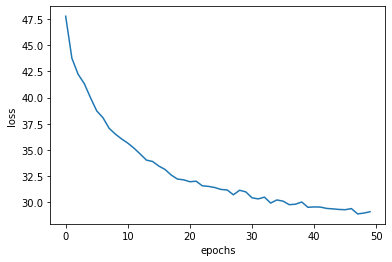

60 2700 28.43471986055374  ETA:  0:03:43.144558
70 3150 27.70328652858734  ETA:  0:03:42.988532
80 3600 27.22164613008499  ETA:  0:03:38.051568
90 4050 26.92755353450775  ETA:  0:03:33.826006
100 4500 26.758322298526764  ETA:  0:03:29.775104


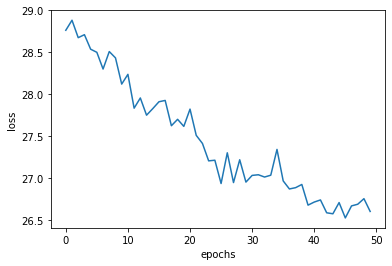

110 4950 26.300805687904358  ETA:  0:03:38.667913
120 5400 26.074918150901794  ETA:  0:04:04.955425
130 5850 26.217041552066803  ETA:  0:04:00.741885
140 6300 25.84091228246689  ETA:  0:03:57.906627
150 6750 25.797544717788696  ETA:  0:03:57.214770


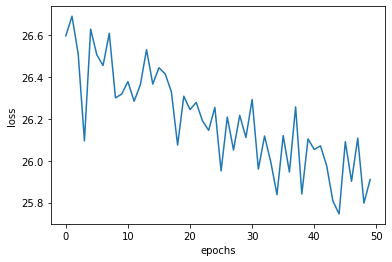

160 7200 25.974778056144714  ETA:  0:04:00.676628
170 7650 25.656518161296844  ETA:  0:04:01.647610
180 8100 25.291723251342773  ETA:  0:03:56.035347
190 8550 25.40750962495804  ETA:  0:03:55.117135
200 9000 25.437929689884186  ETA:  0:03:48.300456


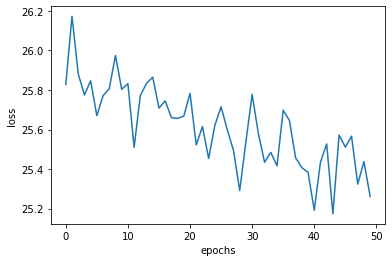

210 9450 25.425934493541718  ETA:  0:03:42.307165
220 9900 25.029851406812668  ETA:  0:03:36.134640
230 10350 25.26254627108574  ETA:  0:03:31.450962
240 10800 25.11856585741043  ETA:  0:03:25.810248
250 11250 25.049184650182724  ETA:  0:03:20.380039


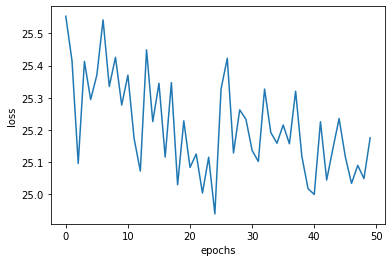

260 11700 24.945459753274918  ETA:  0:03:15.444632
270 12150 24.95663148164749  ETA:  0:03:10.365365
280 12600 24.966963350772858  ETA:  0:03:06.263372
290 13050 24.92966240644455  ETA:  0:03:01.424755
300 13500 24.96487471461296  ETA:  0:02:56.743332


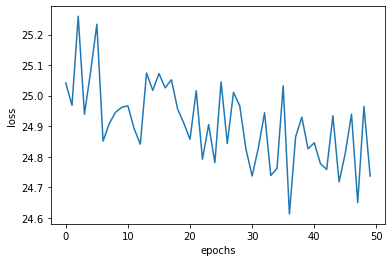

310 13950 24.8564230799675  ETA:  0:02:52.382084
320 14400 24.71854341030121  ETA:  0:02:48.270393
330 14850 24.935772359371185  ETA:  0:02:45.244131
340 15300 24.63765037059784  ETA:  0:02:40.853068
350 15750 24.48286697268486  ETA:  0:02:36.532596


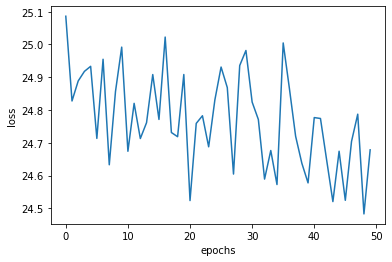

360 16200 24.673158943653107  ETA:  0:02:32.494351
370 16650 24.541184842586517  ETA:  0:02:28.311502
380 17100 24.471173733472824  ETA:  0:02:24.704551
390 17550 24.44881382584572  ETA:  0:02:20.649478
400 18000 24.58760178089142  ETA:  0:02:17.290740


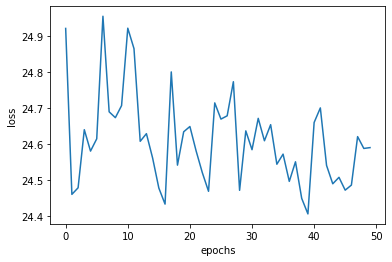

410 18450 24.390863120555878  ETA:  0:02:13.676538
420 18900 24.385007083415985  ETA:  0:02:09.729431
430 19350 24.38701143860817  ETA:  0:02:06.752981
440 19800 24.37614154815674  ETA:  0:02:02.858702
450 20250 24.512353748083115  ETA:  0:01:59.020628


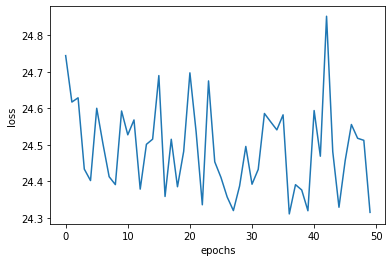

460 20700 24.409403443336487  ETA:  0:01:55.316895
470 21150 24.37281247973442  ETA:  0:01:51.551839
480 21600 24.44688454270363  ETA:  0:01:48.105862
490 22050 24.29085674881935  ETA:  0:01:44.411712
500 22500 24.38759618997574  ETA:  0:01:40.760960


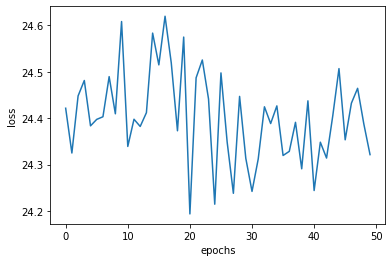

510 22950 24.54972791671753  ETA:  0:01:38.221421
520 23400 24.38734206557274  ETA:  0:01:34.556097
530 23850 24.366070926189423  ETA:  0:01:31.141239
540 24300 24.317774057388306  ETA:  0:01:27.536110
550 24750 24.252481281757355  ETA:  0:01:23.945566


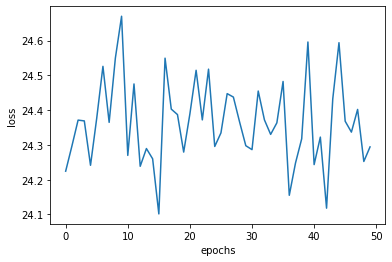

560 25200 24.2598215341568  ETA:  0:01:20.760245
570 25650 24.322945058345795  ETA:  0:01:17.482858
580 26100 24.44589865207672  ETA:  0:01:14.077988
590 26550 24.29019656777382  ETA:  0:01:10.531317
600 27000 24.455603003501892  ETA:  0:01:07.004881


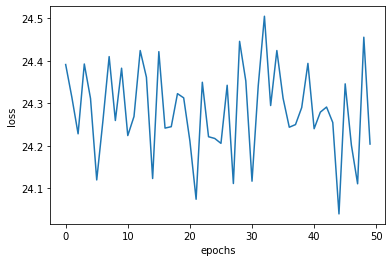

610 27450 24.439267247915268  ETA:  0:01:03.546031
620 27900 24.217538595199585  ETA:  0:01:00.064207
630 28350 24.092212200164795  ETA:  0:00:56.710623
640 28800 24.144779175519943  ETA:  0:00:53.259532
650 29250 24.471134811639786  ETA:  0:00:49.823004


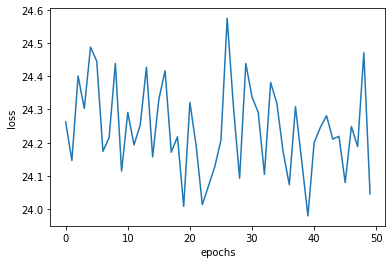

660 29700 24.20260065793991  ETA:  0:00:46.439186
670 30150 24.186094909906387  ETA:  0:00:43.037557
680 30600 24.17068701982498  ETA:  0:00:39.728999
690 31050 24.310397416353226  ETA:  0:00:36.350395
700 31500 24.17246624827385  ETA:  0:00:32.982493


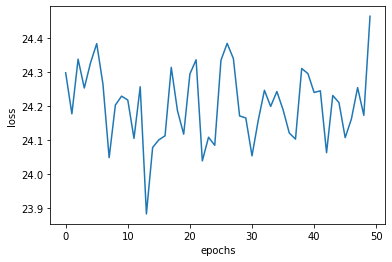

710 31950 24.4410662651062  ETA:  0:00:29.650750
720 32400 24.35506984591484  ETA:  0:00:26.310368
730 32850 24.117918372154236  ETA:  0:00:23.023039
740 33300 24.11434757709503  ETA:  0:00:19.700243
750 33750 24.09417986869812  ETA:  0:00:16.390264


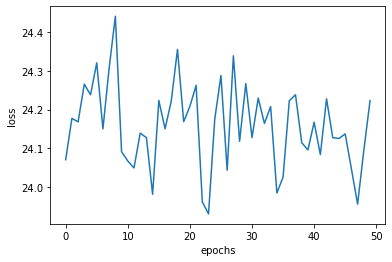

760 34200 24.17153850197792  ETA:  0:00:13.098034
770 34650 24.0759234726429  ETA:  0:00:09.808313
780 35100 24.061990320682526  ETA:  0:00:06.540015
790 35550 23.999009609222412  ETA:  0:00:03.265056


In [223]:
#時間を計測(マジックコマンド)
#%%time
#スタート時刻
start = time()
#記録用のリスト
list_loss = []
#記録用の変数
batch_count = 0

#学習の処理を最大epoch数繰り返す
for epoch in range(max_epoch):

  #ログ：残り時間等
  if epoch >0 and epoch % 10 == 0:
    print(epoch, batch_count, epoch_loss, ' ETA: ', (max_epoch-epoch)*timedelta(seconds = time()-start)/(epoch))

  epoch_loss = 0 #epoch毎の損失の合計

  # dataloaderからバッチを取り出す（10回で終了）
  #for i, (ss, season, mnth, weekday, workday, hr, weathersit, weatherv, target) in zip(range(10), dataloader):
  for i, (ss, season, mnth, weekday, workday, hr, weathersit, weatherv, target) in enumerate(dataloader):

    #前に計算した勾配をリセット(0にする)
    optimizer.zero_grad()

    #ネットワークの出力を計算（入力変数はGPUにコピー）
    out = regressor(ss.to(device), season.to(device), mnth.to(device), weekday.to(device), 
                    workday.to(device), hr.to(device), weathersit.to(device), weatherv.to(device))
    
    #損失関数を計算
    #loss = torch.sum(abs(target.to(device) - out))
    loss = lossfunc_l1(target.to(device), out)

    #逆伝播の勾配を計算
    loss.backward()

    #モデルパラメタの更新
    optimizer.step()

    #epoch損失の累積
    epoch_loss += torch.sqrt(loss).item()
    #バッチ数の更新
    batch_count += 1

  #scheduler.step() #学習率のスケジューリング

  #epoch損失の記録
  list_loss.append(epoch_loss)

  #学習曲線
  if epoch > 0 and epoch % 50 ==0:
    #学習曲線プロット
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(list_loss[-50:])
    plt.show()

In [224]:
#保存用のパスを設定
logpath = '/content/'

In [225]:
#学習したモデルを保存
torch.save(regressor.state_dict(), logpath+'regressor_'+str(max_epoch)+'.pkl')

#モデル読み込み

In [ ]:
#ファイルエリアにpklファイルを置いてから実行
#<All keys matched successfully>と出力されれば読み込み成功
#regressor.load_state_dict(torch.load(logpath+'regressor_100.pkl'))

#予測

In [233]:
#テストデータとローダ
testset=TensorDataset(torch.Tensor(sequence_test), 
                      torch.LongTensor(mode_test[:,0]),
                      torch.LongTensor(mode_test[:,1]),
                      torch.LongTensor(mode_test[:,2]),
                      torch.LongTensor(mode_test[:,3]),
                      torch.LongTensor(mode_test[:,5]),  
                      torch.LongTensor(mode_test[:,4]), #除外した変数 weathersit
                      torch.FloatTensor(average_test), #除外した変数 weatherv
                      torch.FloatTensor(target_test)
                      )

testloader=DataLoader(dataset=testset, shuffle=False, drop_last=False, batch_size=batchsize)

In [227]:
#評価モード（勾配を計算しない）
regressor.eval()

LSTMRegressor(
  (lstm): LSTM(1, 10, batch_first=True)
  (embedding_season): Embedding(4, 2)
  (embedding_mnth): Embedding(12, 2)
  (embedding_weekday): Embedding(7, 2)
  (embedding_workingday): Embedding(2, 2)
  (embedding_hr): Embedding(24, 2)
  (embedding_weathersit): Embedding(3, 2)
  (linear): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [228]:
dataloader = DataLoader(dataset=dataset, shuffle=False, drop_last=False, batch_size=batchsize)

In [229]:
#学習済みモデルの訓練データに対する予測を計算
%%time
#40sec
train_pred_list = []
train_loss_sum = 0
batch_count = 0

for i, (ss, season, mnth, weekday, workday, hr, weathersit, weatherv, target) in enumerate(dataloader):

    out = regressor(ss.to(device), season.to(device), mnth.to(device), weekday.to(device), 
                    workday.to(device), hr.to(device), weathersit.to(device), weatherv.to(device))

    loss = lossfunc_l1(target.to(device), out)

    train_pred_list.append(out.tolist())
    train_loss_sum += torch.sqrt(loss).item()
    batch_count += 1

train_pred_array = np.concatenate(train_pred_list)
print(train_pred_array.shape)
print(batch_count)

(5760, 1)
45
CPU times: user 175 ms, sys: 993 µs, total: 176 ms
Wall time: 175 ms


In [234]:
#学習済みモデルのテストデータに対する予測を計算

%%time 
#25sec
test_pred_list = []
test_loss_sum = 0
batch_count = 0

for i, (ss, season, mnth, weekday, workday, hr, weathersit, weatherv, 
        target) in enumerate(testloader):
    #出力を計算
    out = regressor(ss.to(device), season.to(device), mnth.to(device), weekday.to(device), 
                    workday.to(device), hr.to(device), weathersit.to(device), weatherv.to(device)
                    )
    #損失
    loss = lossfunc_l1(target.to(device), out)

    #出力・損失をリストに保存(tolist,item：値が自動的CPUのメモリにコピーされるので異なるデバイス間のエラーが出難い)
    test_pred_list.append(out.tolist())
    test_loss_sum += torch.sqrt(loss).item()

    batch_count+=1

print(batch_count)

#出力の結合(numpy配列)
test_pred_array = np.concatenate(test_pred_list)

print(test_pred_array.shape)

24
(2975, 1)
CPU times: user 93.8 ms, sys: 0 ns, total: 93.8 ms
Wall time: 93.2 ms


In [ ]:
#世代数
print(train_loss_sum)
print(test_loss_sum)

#視覚的検証

In [ ]:
df_train_pred = pd.DataFrame({'target':target_train.flatten(),
                           'pred': train_pred_array.flatten()},
                          index=pd.to_datetime(series_target_train.index[series_target_train]))
df_train_pred.plot(alpha=0.3,figsize=(20,4))

In [ ]:
#年月でDFを分割するためdate項目を追加
df_train_pred_ym = df_train_pred.assign(ym = pd.Series(df_train_pred.index).apply(lambda x:str(x)[:7]).values)

In [ ]:
fig, axes = plt.subplots(12,1, figsize=(20,64))

for (i,j), ax in zip(df_train_pred_ym.groupby('ym'), axes.ravel()):
  j.drop('ym',axis=1).plot(title=i, marker='x', ax=ax)

plt.show()

In [ ]:
df_test_pred = pd.DataFrame({'target':target_test.flatten(),
                             'pred':test_pred_array.flatten()},
                            index=series_target_test.index[series_target_test])

df_test_pred.plot(alpha=0.3, figsize=(20,4))

In [ ]:
#年月でDFを分割するためdate項目を追加
df_test_pred_ym = df_test_pred.assign(date = pd.Series(df_test_pred.index).apply(lambda x:str(x)[:7]).values)
df_test_pred_ym

In [ ]:
fig, axes = plt.subplots(6,2, figsize=(16,32))

for (i,j), ax in zip(df_test_pred_ym.groupby('date'), axes.ravel()):
  j.plot(title=i, marker='x', ax=ax)

plt.show()

#学習後の検証事項

予測が単なる後追いになっていないか

損失関数が適切か（絶対誤差・二乗誤差）

時間変動のパターンが再現されているか


#課題
適宜パラメタなどを変更してプログラムを実行し，以下の例のような考察検証する

* テストデータのプロットで検証事項について考察
* 過適合の検証（収束直後のモデルと収束後に学習を続けたモデルでテスト損失を比較）
* 収束に要する epoch 数 (epoch vs 損失のプロットを作成する)
* 学習の収束前と収束後の予測の違い（学習 epoch数の少ないモデルと収束後のモデルでプロットを比較する）
* 損失関数による違い（MSEの場合とL1の場合のプロットを作成して比較する）
* 静的変数を除いた場合の損失と視覚的な検証

#レポート

TeX形式で考察・検証した内容を記述する